In [1]:
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.fft as scft
import sys
import stingray as st
import os

sys.path.insert(1, 'C:/Users/shash/UvA/Thesis/Project/MastersThesis/src/MastersThesis/scripts')

from General import *
from PowerSpec import *
from BiSpectra import *
from SimulatorFuncs import *
from CrossBispec import *
from Stats_and_Fits import get_chi_sqr

In [2]:
f = open('C:/Users/shash/UvA/Thesis/Project/MastersThesis/src/MastersThesis/scripts/ColorCycle.txt', 'r')
colors = f.read().replace(' ', '').split(',')

In [3]:
def get_indices_temp(freq, min, max):
    return np.argmin(np.abs(freq-min)), np.argmin(np.abs(freq-max))
def obj_fcn2(params, data_x, data_y, model, n_stacked):
    """
    Log likelihood function to be used for fitting.
    
    """
    # m = PDS_reb.m # Number of stacked periodograms
    # data_x = xdat 
    # data_y = ydat
    model_y = model.eval(params=params, f=data_x)
    
    S = 2 * np.sum(n_stacked * (data_y/model_y + np.log(model_y) + (1/n_stacked - 1) * np.log(data_x) + 100*n_stacked))

    # return (data_y - model_y)**2/(data_y/np.sqrt(n_stacked))**2
    
    # print(S)

    return S
def ind_const_model(f, c):
    return f / f * c

In [4]:
data_dir = '../../data/'
obsids = ['ni1050360104', 'ni1050360105', 'ni1050360106', 'ni1050360107', 'ni1050360108', 'ni1050360109', 'ni1130360112', 'ni1130360114', 'ni1130360113']

# Initializing directories

In [6]:
data_dir = '../../data/'
obsids = ['ni1050360104', 'ni1050360105', 'ni1050360106', 'ni1050360107', 'ni1050360108', 'ni1050360109', 'ni1130360112', 'ni1130360114', 'ni1130360113']

for obsid in obsids:
    file_dir = data_dir + f'raw/MAXI/{obsid}_0mpu7_cl.evt'

    # Working directory to store all the pspec fit results
    # Will also check this directory for whether fit results are already present
    save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning//SingleBin/{obsid}/PspecFits/'

    cbs_save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/SingleBin/{obsid}/cbs_arrs_singlebin/'

    bigsegs_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/SingleBin/{obsid}/bigsegs/'
    # Check that these directories exist:
    if not os.path.exists(file_dir):
        print("Specified event file does not exist")
    if not os.path.isdir(save_dir):
        print("Save directory does not exist, making one!")
        os.makedirs(save_dir)
    if not os.path.isdir(cbs_save_dir):
        print("Direcotry to save cbs does not exist, creating one!")
        os.mkdir(cbs_save_dir)
    if not os.path.isdir(bigsegs_dir):
        print("Direcotry to save cbs does not exist, creating one!")
        os.mkdir(bigsegs_dir)
    else:
        print("Files and directories seem to exist, you can continue :)")

Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)
Files and directories seem to exist, you can continue :)


In [ ]:
# !!! Need to add a check for whether these files already exist !!!


# Split into separate event files and save
data_dir = '../../data/'
obsids = ['ni1050360104', 'ni1050360105', 'ni1050360106', 'ni1050360107', 'ni1050360108', 'ni1050360109', 'ni1130360112', 'ni1130360114', 'ni1130360113']

for obsid in obsids:

    print(f"-------------------------------\nWorking on obsid {obsid}\n-------------------------------")

    evtfile_dir = data_dir + f'raw/MAXI/{obsid}_0mpu7_cl.evt'

    # Define where to save the eventlist split into big segments
    bigseg_save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/FinerEnergyBinning2/{obsid}/bigsegs/'

    if not os.path.isdir(bigseg_save_dir):
        print("Save directory does not exist, making one!")
        os.makedirs(bigseg_save_dir)


    eventlist_full = st.EventList.read(evtfile_dir, "hea")
    eventlist_full = eventlist_full.filter_energy_range([.5,10])
    print("Saving full eventlist in the energy range 0.5 to 10 keV")
    eventlist_full.write(f'{bigseg_save_dir}fullev_{obsid}.p', "pickle")
    
    # Split eventlist into big segments
    _ = 0
    gti_durations = []
    t_split_values = []
    time_accumulated = 0
    time_per_segment = 256 * 2
    time_required = time_per_segment

    for gti in eventlist_full.gti:
        t_start = gti[0]
        t_end = gti[-1]
        t_dur = t_end - t_start
        time_accumulated += t_dur
        
        # If current gti has less time than still reqiured
        if t_dur < time_required:
            time_required -= t_dur
        
        # If current gti is bigger than time still required
        else:
            end_of_gti = False # Keeps track of whether we have reached the end of the gti
            
            # First add the time still required
            t_split_values.append(gti[0] + time_required)
            # Reset time required
            time_required = time_per_segment
            
            while not end_of_gti:
                
                # Keep adding segments if we can fit them in
                if time_required + t_split_values[-1] <= gti[-1]:
                    # Append another t_split marker
                    t_split_values.append(t_split_values[-1] + time_required)
                
                # When we can't fit another segment, we have reached the end of the gti
                else:
                    end_of_gti = True
                    # Remove the rest of the gti from the time required
                    time_required -= gti[-1] - t_split_values[-1]
    
    events_split_by_time = []
    
    print("Splitting into big segs and saving split eventlists (full energy range)")

    for i in range(len(t_split_values)):
        if i == 0:
            mask = (eventlist_full.time<=t_split_values[i])
            masked_ev = eventlist_full.apply_mask(mask)
            events_split_by_time.append(masked_ev)

        else:
            mask = (eventlist_full.time>=t_split_values[i-1]) & (eventlist_full.time<t_split_values[i])
            masked_ev = eventlist_full.apply_mask(mask)
            events_split_by_time.append(masked_ev)

    # obsid = ni1130360112: first two big segs dont have a well defined QPO

    if obsid == 'ni1130360112':
        print("Correcting for obsid", obsid)
        events_split_by_time = events_split_by_time[2:]

    if obsid == 'ni1130360113':
        print("Correcting for obsid", obsid)
        events_split_by_time.pop(4)

    for i, masked_ev in enumerate(events_split_by_time):
        masked_ev.write(f'{bigseg_save_dir}splitev_{obsid}_{i}.p', "pickle")

    print(f'The full eventlist has been split into {len(events_split_by_time)} \"Big Segments\".')

-------------------------------
Working on obsid ni1130360113
-------------------------------
Saving full eventlist in the energy range 0.5 to 10 keV
Splitting into big segs and saving split eventlists (full energy range)
Correcting for obsid ni1130360113
The full eventlist has been split into 9 "Big Segments".


# Creating Power Spectra

## Split eventfile based on given 'segment' size

Need to do this for one obsid at a time

In [16]:
obsids = ['ni1050360104', 'ni1050360105', 'ni1050360106', 'ni1050360107', 'ni1050360108', 'ni1050360109', 'ni1130360112', 'ni1130360113', 'ni1130360114']
obsid = obsids[0]

# Directory to load
file_dir = data_dir + f'raw/MAXI/{obsid}_0mpu7_cl.evt'

# Working directory to store all the pspec fit results
# Will also check this directory for whether fit results are already present
# save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning//FinerEnergyBinning2/{obsid}/PspecFits/'

# cbs_save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/FinerEnergyBinning2/{obsid}/cbs_arrs/'

# bigsegs_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/FinerEnergyBinning2/{obsid}/bigsegs/'

save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning//SingleBin/{obsid}/PspecFits/'

cbs_save_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/SingleBin/{obsid}/cbs_arrs_singlebin/'

bigsegs_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/SingleBin/{obsid}/bigsegs/'

# Load all big segments for a given obsid #

# Check how many pickle files of splitevs exist
count_pickle = 0
for file in os.listdir(bigsegs_dir):
    if file.endswith('.p') and file.startswith('splitev'):
        count_pickle += 1

# Load big segments
events_split_by_time = []
for i in range(count_pickle):
    ev_file_dir = f'{bigsegs_dir}splitev_{obsid}_{i}.p'
    ev_loaded = st.EventList.read(ev_file_dir, "pickle")
    events_split_by_time.append(ev_loaded)

print(f'Loaded {len(events_split_by_time)} big segments into events_split_by_time')

Loaded 10 big segments into events_split_by_time


In [17]:
# Check if powerspectra fits already exist
files_exist = True
for i in range(len(events_split_by_time)):
    if not os.path.exists(f'{save_dir}pspec_fit_{i}.png'):
        files_exist = False
        break
if os.path.exists(f'{save_dir}pspec_fit_result_{i}.npz'):
    files_exist = False

if not files_exist:
    print("Some of the required power spectrum fits do not exist in the given directory and will be generated")
else:
    print("Required fits alrady exist, skipping the fitting part of the script.")

Required fits alrady exist, skipping the fitting part of the script.


## Fit power spectrum for each segmented event file

In [18]:
if not files_exist:
    _ = 0

    fund_fwhm = []
    fund_central_f = []

    seg_size=32
    for event in events_split_by_time[:]:

        PDS_e1 = st.AveragedPowerspectrum(event, segment_size=seg_size, dt=1/64, norm='frac')

        avg_countrate = st.fourier.get_average_ctrate(event.time, event.gti, segment_size=seg_size)
        noise_init = st.fourier.poisson_level('frac', meanrate=avg_countrate)

        PDS_e1_reb = PDS_e1.rebin_log(f=0.03)

        full_model = lmfit.Model(lorentz_fwhm, prefix='fund_') + lmfit.Model(lorentz_fwhm, prefix='harm_') + lmfit.Model(lorentz_fwhm, prefix='Bbn1_') + lmfit.Model(lorentz_fwhm, prefix='Bbn2_') +  lmfit.Model(ind_const_model, prefix='poisson_')
        params=lmfit.Parameters()


        # Inital Params for Results 2
        # params.add('fund_lor_rmssq', value=0.005, min=0)
        # params.add('fund_f_cent', value=2, min=0)
        # params.add('fund_fwhm', value=.5, min=0)

        # params.add('harm_f_cent', expr='2.0*fund_f_cent')
        # params.add('harm_lor_rmssq', value=0.003, min=0)
        # params.add('harm_fwhm', value=1, min=0)

        # params.add('Bbn1_lor_rmssq', value=0.01, min=0)
        # params.add('Bbn1_f_cent', value=.3, min=0)
        # params.add('Bbn1_fwhm', value=1, min=0)

        # params.add('Bbn2_lor_rmssq', value=0.01, min=0)
        # params.add('Bbn2_f_cent', value=0, min=0)
        # params.add('Bbn2_fwhm', value=10, min=0)

        # params.add('Bbn3_lor_rmssq', value=0.01, min=0)
        # params.add('Bbn3_f_cent', value=30, min=0)
        # params.add('Bbn3_fwhm', value=10, min=0)
        
        # params.add('poisson_c', value=noise_init, min=0)

        params.add('fund_lor_rmssq', value=0.005, min=0)
        params.add('fund_f_cent', value=5, min=0)
        params.add('fund_fwhm', value=.3, min=0)

        params.add('harm_f_cent', expr='2.0*fund_f_cent')
        params.add('harm_lor_rmssq', value=0.003, min=0)
        params.add('harm_fwhm', value=1, min=0)

        params.add('Bbn1_lor_rmssq', value=0.01, min=0)
        params.add('Bbn1_f_cent', value=.3, min=0)
        params.add('Bbn1_fwhm', value=1, min=0)

        params.add('Bbn2_lor_rmssq', value=0.01, min=0)
        params.add('Bbn2_f_cent', value=0, min=0)
        params.add('Bbn2_fwhm', value=10, min=0)

        params.add('Bbn3_lor_rmssq', value=0.01, min=0)
        params.add('Bbn3_f_cent', value=30, min=0)
        params.add('Bbn3_fwhm', value=10, min=0)

        params.add('poisson_c', value=noise_init, min=0)

        # plt.errorbar(PDS_e1_reb.freq, (PDS_e1_reb.power-noise_init) * PDS_e1_reb.freq, yerr=PDS_e1_reb.power_err*PDS_e1_reb.freq, ds='steps-mid')
        # plt.plot(PDS_e1_reb.freq, (full_model.eval(params=params, f=PDS_e1_reb.freq) - noise_init) * PDS_e1_reb.freq, c='red', ls='-.')
        # for mod in full_model.components:
        #     model_pow = mod.eval(params, f=PDS_e1_reb.freq)
        #     plt.plot(PDS_e1_reb.freq, (model_pow) * PDS_e1_reb.freq, linestyle='-.', label=mod.prefix[:-1])
            
        result = lmfit.minimize(obj_fcn2, params, method='nelder', nan_policy='raise', calc_covar=True, args=(PDS_e1_reb.freq, PDS_e1_reb.power, full_model, PDS_e1_reb.m))
        noise=result.params['poisson_c'].value

        plt.plot(PDS_e1_reb.freq, (full_model.eval(params=result.params, f=PDS_e1_reb.freq) - noise) * PDS_e1_reb.freq, c='K'.lower(), ls='dashed')
        # plt.plot(PDS_full.freq, np.abs(PDS_e1.power - noise) * PDS_e1.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
        plt.errorbar(PDS_e1_reb.freq, (PDS_e1_reb.power-noise) * PDS_e1_reb.freq, yerr=PDS_e1_reb.power_err*PDS_e1_reb.freq, ds='steps-mid', alpha=.4)

        fund_fwhm.append(result.params['fund_fwhm'].value)
        fund_central_f.append(result.params['fund_f_cent'].value)

        for mod in full_model.components:
            model_pow = mod.eval(result.params, f=PDS_e1_reb.freq)
            if mod.prefix[:-1] != 'poisson':
                plt.plot(PDS_e1_reb.freq, (model_pow) * PDS_e1_reb.freq, linestyle='dashed', label=mod.prefix[:-1])
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim(1e-5, 1e-1)
        plt.legend()
        
        plt.savefig(f'{save_dir}pspec_fit_{_}.png')
        plt.close()
        _ += 1
else:
    print("Skipping fits, will just load saved results")

Skipping fits, will just load saved results


## Manually inpsect the fits and identify incorrect ones

Incorrect indices: 0, 1, 2, 12

In [19]:
if not files_exist:
    
    # Change this index to manually fit specific segments
    _ = 0
    
    event = events_split_by_time[_]
    PDS_e1 = st.AveragedPowerspectrum(event, segment_size=seg_size, dt=1/64, norm='frac')

    avg_countrate = st.fourier.get_average_ctrate(event.time, event.gti, segment_size=seg_size)
    noise_init = st.fourier.poisson_level('frac', meanrate=avg_countrate)

    PDS_e1_reb = PDS_e1.rebin_log(f=0.04)


    full_model = lmfit.Model(lorentz_fwhm, prefix='fund_') + lmfit.Model(lorentz_fwhm, prefix='harm_') + lmfit.Model(lorentz_fwhm, prefix='Bbn1_') + lmfit.Model(lorentz_fwhm, prefix='Bbn2_') +  lmfit.Model(ind_const_model, prefix='poisson_')
    params=lmfit.Parameters()


    # Inital Params for Results 2
    params.add('fund_lor_rmssq', value=0.005, min=0)
    params.add('fund_f_cent', value=5, min=0)
    params.add('fund_fwhm', value=.5, min=0)

    params.add('harm_f_cent', expr='2.0*fund_f_cent')
    params.add('harm_lor_rmssq', value=0.003, min=0)
    params.add('harm_fwhm', value=1, min=0)

    params.add('Bbn1_lor_rmssq', value=0.01, min=0)
    params.add('Bbn1_f_cent', value=.3, min=0)
    params.add('Bbn1_fwhm', value=1, min=0)

    params.add('Bbn2_lor_rmssq', value=0.01, min=0)
    params.add('Bbn2_f_cent', value=0, min=0)
    params.add('Bbn2_fwhm', value=10, min=0)

    params.add('Bbn3_lor_rmssq', value=0.01, min=0)
    params.add('Bbn3_f_cent', value=30, min=0)
    params.add('Bbn3_fwhm', value=10, min=0)

    params.add('poisson_c', value=noise_init, min=0)

    # plt.errorbar(PDS_e1_reb.freq, (PDS_e1_reb.power-noise_init) * PDS_e1_reb.freq, yerr=PDS_e1_reb.power_err*PDS_e1_reb.freq, ds='steps-mid')
    # plt.plot(PDS_e1_reb.freq, (full_model.eval(params=params, f=PDS_e1_reb.freq) - noise_init) * PDS_e1_reb.freq, c='red', ls='-.')
    # for mod in full_model.components:
    #     model_pow = mod.eval(params, f=PDS_e1_reb.freq)
    #     plt.plot(PDS_e1_reb.freq, (model_pow) * PDS_e1_reb.freq, linestyle='-.', label=mod.prefix[:-1])
        
    result = lmfit.minimize(obj_fcn2, params, method='nelder', nan_policy='raise', calc_covar=True, args=(PDS_e1_reb.freq, PDS_e1_reb.power, full_model, PDS_e1_reb.m))
    noise=result.params['poisson_c'].value

    plt.plot(PDS_e1_reb.freq, (full_model.eval(params=result.params, f=PDS_e1_reb.freq) - noise) * PDS_e1_reb.freq, c='K'.lower(), ls='dashed')
    # plt.plot(PDS_full.freq, np.abs(PDS_e1.power - noise) * PDS_e1.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
    plt.errorbar(PDS_e1_reb.freq, (PDS_e1_reb.power-noise) * PDS_e1_reb.freq, yerr=PDS_e1_reb.power_err*PDS_e1_reb.freq, ds='steps-mid', alpha=.6, label='Data')

    fund_fwhm[_] = result.params['fund_fwhm'].value
    fund_central_f[_] = result.params['fund_f_cent'].value

    for mod in full_model.components:
        model_pow = mod.eval(result.params, f=PDS_e1_reb.freq)
        if mod.prefix[:-1] != 'poisson':
            plt.plot(PDS_e1_reb.freq, (model_pow) * PDS_e1_reb.freq, linestyle='dashed', label=mod.prefix[:-1])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-5, 1e-1)
    plt.legend()

    plt.savefig(f'{save_dir}pspec_fit_{_}.png')
    plt.show()
    # plt.close()
else:
    print("Skipping fits, will just load saved results")

Skipping fits, will just load saved results


In [20]:
# Save the fit results - the fwhm and fundamental frequency - to a text file
if not files_exist:
    print(f"Saving fit results to:\n{save_dir}pspec_fit_result.npz")
    fund_arr = np.array(fund_central_f)
    fund_fwhm_arr = np.array(fund_fwhm)
    np.savez(f'{save_dir}pspec_fit_result', f_cent=fund_arr, f_fwhm=fund_fwhm_arr)

# Load already present fits
else:
    print(f"Loading saved fits from:\n{save_dir}pspec_fit_result.npz")
    a =np.load(f'{save_dir}pspec_fit_result.npz')
    fund_central_f = a['f_cent']
    fund_fwhm = a['f_fwhm']

Loading saved fits from:
../../data/processed/20250507_FrequencyDependentBinning//SingleBin/ni1050360104/PspecFits/pspec_fit_result.npz


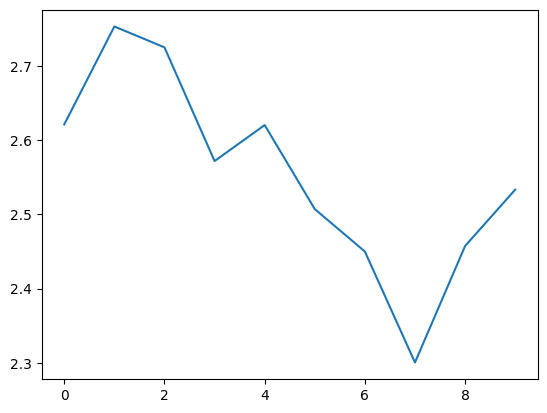

In [21]:
plt.plot(fund_central_f)
# fund_fwhm.shape

# Cross Bispectra

In [47]:
temp_index = 0

In [62]:
obsid = obsids[temp_index]
temp_index+=1
# Directory to load
file_dir = data_dir + f'raw/MAXI/{obsid}_0mpu7_cl.evt'

# Working directory to store all the pspec fit results
# Will also check this directory for whether fit results are already present
obs_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/SingleBin/{obsid}/'

bigsegs_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning/SingleBin/{obsid}/bigsegs/'

load_fund_freq_from = f'{obs_dir}PspecFits/pspec_fit_result.npz'

# Check how many pickle files of splitevs exist
count_pickle = 0
for file in os.listdir(bigsegs_dir):
    if file.endswith('.p') and file.startswith('splitev'):
        count_pickle += 1

# Load big segments
events_split_by_time = []
for i in range(count_pickle):
    ev_file_dir = f'{bigsegs_dir}splitev_{obsid}_{i}.p'
    ev_loaded = st.EventList.read(ev_file_dir, "pickle")
    events_split_by_time.append(ev_loaded)

print(f'Loaded {len(events_split_by_time)} big segments into events_split_by_time')

temp_loader = np.load(load_fund_freq_from)
fund_central_f = temp_loader['f_cent']
fund_fwhm = temp_loader['f_fwhm']

print(f'Loaded fund freqs and fwhm from:\n{load_fund_freq_from}')

Loaded 14 big segments into events_split_by_time
Loaded fund freqs and fwhm from:
../../data/processed/20250507_FrequencyDependentBinning/SingleBin/ni1050360105/PspecFits/pspec_fit_result.npz


In [63]:
cbs_save_dir = f'{obs_dir}cbs_arrs_singlebin/'
print(f'Created cross bispec will be saved to:\n{cbs_save_dir}')

Created cross bispec will be saved to:
../../data/processed/20250507_FrequencyDependentBinning/SingleBin/ni1050360105/cbs_arrs_singlebin/


In [65]:
dt = 1/64
E_range_edges = np.array([0.5, 1, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5, 7, 8, 10])
E_range_centre = (E_range_edges[1:] + E_range_edges[:-1]) / 2

np.save(f'{cbs_save_dir}EnergyBinEdges', E_range_edges)

calc_only_biphase = True
calc_both = False

for count, ev in enumerate(events_split_by_time):
    print("Working on big seg", count)
    
    # Set segment size for cbsepc based on qpo frequency
    # Cbspec_segsize = 12 * 1/fund_central_f[count]
    Cbspec_segsize = 4
    
    # Assuming Q = 8 to get FWHM
    Q = 8
    fwhm = fund_central_f[count]/Q
    
    # Filter out reference band light curve
    E_ref = [2, 10]
    EnergyLabels = [f'{E_ref[0]:.1f}-{E_ref[1]:.1f} KeV']
    
    events_E_ref = ev.filter_energy_range(E_ref)
    events_filtered = [events_E_ref]
    
    lc_ref = events_filtered[0].to_lc(dt=dt)
    segmented_counts_E_ref, segmented_times_E_ref, discard = split_multiple_lc(lc_ref.split_by_gti(), Cbspec_segsize, dt=dt)

    if calc_only_biphase or calc_both:
        avg_cbspec, freq, ind_bspec = avg_cross_bispec(segmented_counts_E_ref, segmented_counts_E_ref, 0.1, 10, dt=dt, ret_ind_cbs=True)
        
        min_ind, max_ind = get_indices_temp(freq, fund_central_f[count] - fwhm/2, fund_central_f[count] + fwhm/2)
        fund_bin, discard = get_indices_temp(freq, fund_central_f[count], fund_central_f[count])
        
        # Over FWHM
        # bspec = np.mean(np.diagonal(ind_bspec, axis1=2, axis2=1)[:, min_ind:max_ind+1], axis=1)
        
        # Single bin
        bspec = ind_bspec[:, fund_bin, fund_bin]
        np.save(f'{cbs_save_dir}ref_band_bspec_{count}', bspec)

    if not calc_only_biphase or calc_both:
        for c in range(len(E_range_edges)-1):
            # print(f'{E_range_edges[c]:.2f} to {E_range_edges[c+1]:.2f} keV')
            E_filtered = [E_range_edges[c], E_range_edges[c+1]]

            EnergyLabels.append(f'{E_range_edges[c]:.1f}-{E_range_edges[c+1]:.1f} KeV')
            events_filtered.append(ev.filter_energy_range(E_filtered))

        min_ind, max_ind = None, None
        # Calculate energy dependant cross-bispec
        E_dep_cbspec = []
        for events in events_filtered:
            lc_subject = events.to_lc(dt=dt)
            segmented_counts_E_sub, segmented_times_E_sub, discard = split_multiple_lc(lc_subject.split_by_gti(), Cbspec_segsize, dt=dt)
            avg_cbspec, freq, ind_cbspec = avg_cross_bispec(segmented_counts_E_ref, segmented_counts_E_sub, 0.1, 10, dt=dt, ret_ind_cbs=True)

            if min_ind is None:
                min_ind, max_ind = get_indices_temp(freq, fund_central_f[count] - fwhm/2, fund_central_f[count] + fwhm/2)
                fund_bin, discard = get_indices_temp(freq, fund_central_f[count], fund_central_f[count])
            
            # Select cbs in required freq range - FWHM            
            # temp_var = np.mean(np.diagonal(ind_cbspec, axis1=2, axis2=1)[:, min_ind:max_ind+1], axis=1)

            # Single bin
            temp_var = ind_cbspec[:, fund_bin, fund_bin]
            # print(fund_bin, ind_cbspec[:, fund_bin, fund_bin].shape)
            
            E_dep_cbspec.append(temp_var)
            
            # break

        E_dep_cbspec = np.array(E_dep_cbspec)
        print(E_dep_cbspec.shape)

        np.save(f'{cbs_save_dir}cbs_from_bigsegs_ind_{count}', E_dep_cbspec)

Working on big seg 0


c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


KeyboardInterrupt: 

# Creating cross-bispectra - depracated

In [63]:
def sample_segmented_counts_cbspec(lc_counts_segmented_1,lc_counts_segmented_2, n_samples):
    """
    Samples segmented counts, to be used with bootstrapping. Need to eventually change this to be able to directly sample the FTs
    """
    sampled_indices = np.random.choice(len(lc_counts_segmented_1), n_samples)
    sample_1 = lc_counts_segmented_1[sampled_indices]
    sample_2 =lc_counts_segmented_2[sampled_indices]
    return sample_1, sample_2


def get_phase_errors_cbs_singlebin(lc_segmented_counts_ref, lc_segmented_counts_sub, dt, min_cbsfreq, max_cbsfreq, QPO_fund_freq, n_samples, n_bs_iters, central_phase=0,  norm='none', pois_correction=False):
    """
    Calculate average phase and std by sampling light curve segments.
    
    central_phase defines either a 0 to 2 pi range or - pi to pi range.
    """
    phase_list = []
    for c in range(n_bs_iters):
        sampled_segments_ref, sampled_segments_sub = sample_segmented_counts_cbspec(lc_segmented_counts_ref, lc_segmented_counts_sub, n_samples)
        # c
        # bspec, freq_bspec = avg_bispec(sampled_segments_ref, sampled_segments_sub, dt, min_bsfreq, max_bsfreq, norm='none', pois_correction=pois_correction)

        avg_cross_bspec, freq_crossbispec = avg_cross_bispec(sampled_segments_ref, sampled_segments_sub, min_cbsfreq, max_cbsfreq, dt, norm=norm)
        
        fund_index, discard = get_indices_temp(freq_crossbispec, QPO_fund_freq, QPO_fund_freq)

        if central_phase==0:
            phase = np.angle(avg_cross_bspec[fund_index, fund_index])
            phase_list.append(phase)
        elif central_phase == np.pi:
            angle = np.angle(avg_cross_bspec[fund_index, fund_index])
            if angle<0:
                angle = 2 * np.pi + angle
            phase = angle
            phase_list.append(phase)
        else:
            print("I can only handle central phase of 0 or pi at this point.")
        # break
        
    return np.mean(phase_list), np.std(phase_list)


def get_phase_errors_cbs_avgoverbins(lc_segmented_counts_ref, lc_segmented_counts_sub, dt, min_cbsfreq, max_cbsfreq, QPO_fund_freq, fwhm, n_samples, n_bs_iters, norm='none', pois_correction=False):
    """
    Calculate average phase and std by sampling light curve segments.
    """
    phase_list = []
    calc_central_phase = True
    for _ in range(n_bs_iters):
        sampled_segments_ref, sampled_segments_sub = sample_segmented_counts_cbspec(lc_segmented_counts_ref, lc_segmented_counts_sub, n_samples)

        avg_cross_bspec, freq_crossbispec = avg_cross_bispec(sampled_segments_ref, sampled_segments_sub, min_cbsfreq, max_cbsfreq, dt, norm=norm)
        
        min_avg_index, max_avg_index = get_indices_temp(freq_crossbispec, QPO_fund_freq - fwhm, QPO_fund_freq + fwhm)
        fund_index, discard = get_indices_temp(freq_crossbispec, QPO_fund_freq, QPO_fund_freq)


        # Calculate angles within FWHM
        phase = np.angle(np.diag(avg_cross_bspec)[min_avg_index: max_avg_index+1])

        # Convert to 0 to 2pi domain cos its sooo much easier to visualize
        phase[phase<0] = np.pi*2+phase[phase<0]
        phase[phase>2*np.pi] = -(2*np.pi - phase[phase>2*np.pi])

        theta_p = phase.copy() # Stores phases in new 'coordinate' system

        # Calculate theta_mean, then centre distribution on theta_mean - ie, convert to new coordinate system then take mean
        # Do this a few times to ensure that we encapsulate the distribution correctly
        
        if calc_central_phase:
            
            for i in range(5):
                theta_mean = np.mean(theta_p)
                
                # Center on theta mean
                theta_p[theta_p<theta_mean-np.pi] = 2*np.pi + theta_p[theta_p<theta_mean-np.pi]
                theta_p[theta_p>theta_mean+np.pi] = - (2*np.pi - theta_p[theta_p>theta_mean+np.pi])
                
                # To save some computational time, we assume that theta_mean is consistent between each sampled population 
                # This should be true as long as phase doesnt look like a uniform distribution
                calc_central_phase = False
        else:
            theta_p[theta_p<theta_mean-np.pi] = 2*np.pi + theta_p[theta_p<theta_mean-np.pi]
            theta_p[theta_p>theta_mean+np.pi] = - (2*np.pi - theta_p[theta_p>theta_mean+np.pi])
            
        mean_ph = np.mean(theta_p)
        phase_list.append(mean_ph)
    
    plt.hist(phase_list, bins=30)
    plt.close()
    try:
        plt.title(f'E_ref = {labels[0]} and E_sub = {labels[c]}')
    except:
        print("Labels not defined, not setting plot title")
    plt.xlabel('Phase (rad)')
    plt.ylabel('Counts')
    try:
        plt.savefig(f'{save_dir}E_sub_{labels[c]}_hist.png', dpi=600)
    except:
        print("Couldn't save figure")
    
    # plt.show()
    return np.mean(phase_list), np.std(phase_list)

# Ignore this part

../../data/processed/20250417_FrequencyDependentBinning/ni1130360112/cbs_arrs/cbs_from_bigsegs_cumm_5.npy


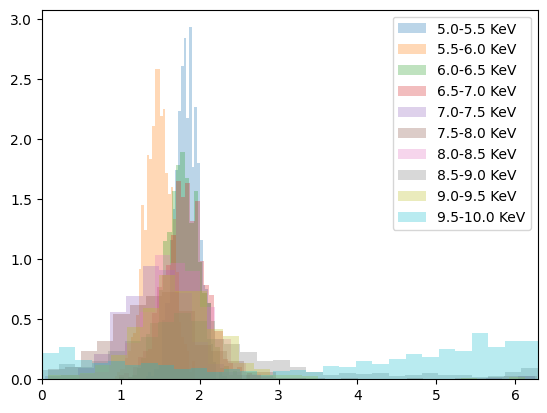

In [ ]:
# load_dir = f'{cbs_save_dir}cbs_from_bigsegs_cumm_10.npy'
load_dir = '../../data/processed/20250417_FrequencyDependentBinning/ni1130360112/cbs_arrs/cbs_from_bigsegs_cumm_5.npy'
print(load_dir)
cbs_vs_E_small_segs = np.load(load_dir)

angle_list = [] # Stores calculated cross-biphase for each 

for i in range(1000):
    # Generate indices to sample from
    sample_indices = np.random.randint(0, cbs_vs_E_small_segs.shape[1], size=cbs_vs_E_small_segs.shape[1])

    # Sample cbs to create new population
    sampled_cbs = cbs_vs_E_small_segs[:, sample_indices]
    # Take a vector sum over cbs for each energy band
    summed_cbs = np.sum(sampled_cbs, axis=1)
    # Calculate cross-biphase
    a = np.angle(summed_cbs)
    # Store calculated energy-dependent cross-biphase
    angle_list.append(a)

# Convert from -pi to pi domain to 0 to 2pi domain
angle_list = np.array(angle_list)
angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])

# Calculate mean cross-biphase and error/std
mean_ph = np.mean(angle_list, axis=0)
std = np.std(angle_list, axis=0)

for i in range(10, 20):
    # print(angle_list[:, i].shape)
    plt.hist(angle_list[:, i], bins=30, alpha=.3, label=labels[i], density=True)
    plt.xlim(0, 2*np.pi)
    plt.legend()
    # plt.show()
    # break


In [238]:
# ni1050360104_mean_ph = mean_ph.copy()
# ni1050360104_std_ph = std.copy()

# ni1050360106_mean_ph = mean_ph.copy()
# ni1050360106_std_ph = std.copy()

# ni1050360105_mean_ph = mean_ph.copy()
# ni1050360105_std_ph = std.copy()

# ni1050360107_mean_ph = mean_ph.copy()
# # ni1050360107_std_ph = std.copy()

# ni1050360108_mean_ph = mean_ph.copy()
# ni1050360108_std_ph = std.copy()

# ni1050360109_mean_ph = mean_ph.copy()
# ni1050360109_std_ph = std.copy()

ni1130360112_mean_ph = mean_ph.copy()
ni1130360112_std_ph = std.copy()

In [239]:
print(save_dir)

../../data/processed/20250417_FrequencyDependentBinning/ni1130360112/PspecFits/


In [241]:
# ni1050360106_freq_range = min(fund_central_f), max(fund_central_f)

# ni1050360106_freq_range = min(fund_central_f), max(fund_central_f), 
# print(ni1050360106_freq_range)

# print(f"Loading saved fits from:\n{save_dir}pspec_fit_result.npz")
a =np.load(f'../../data/processed/20250417_FrequencyDependentBinning/ni1130360112/PspecFits/pspec_fit_result.npz')
fund_central_f = a['f_cent']
fund_fwhm = a['f_fwhm']

# ni1050360106_freq_range = min(fund_central_f), max(fund_central_f)
# print(ni1050360106_freq_range)

# ni1050360105_freq_range = min(fund_central_f), max(fund_central_f)
# print(ni1050360105_freq_range)

# ni1050360104_freq_range = min(fund_central_f), max(fund_central_f)
# print(ni1050360104_freq_range)

# ni1050360107_freq_range = min(fund_central_f), max(fund_central_f)
# print(ni1050360107_freq_range)

# ni1050360108_freq_range = min(fund_central_f), max(fund_central_f)
# print(ni1050360108_freq_range)

# ni1050360109_freq_range = min(fund_central_f), max(fund_central_f)
# print(ni1050360109_freq_range)

ni1130360112_freq_range = min(fund_central_f), max(fund_central_f)
print(ni1130360112_freq_range)

(4.3359918045768415, 5.576067700166009)


[0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 5.25 5.75 6.25 6.75 7.25
 7.75 8.25 8.75 9.25 9.75]


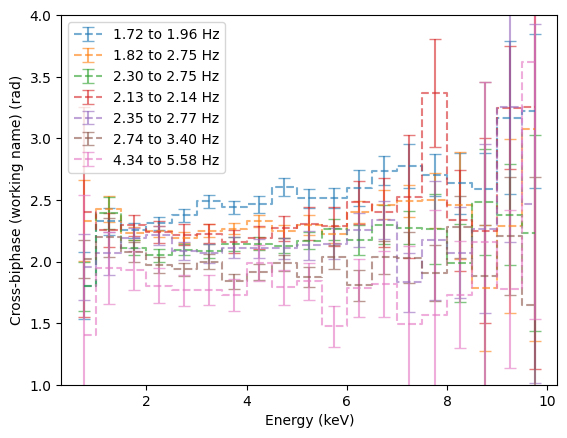

In [249]:
E_range_centre = (E_range_edges[1:] + E_range_edges[:-1]) / 2
# plt.errorbar(range(len(mean_ph)),mean_ph, yerr=std, alpha=.5)
print(E_range_centre)
# plt.errorbar(E_range_centre, mean_ph_1[1:]/np.pi, yerr=std_1[1:]/np.pi, ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
# plt.errorbar(E_range_centre, mean_ph_2[1:]/np.pi, yerr=std_2[1:]/np.pi, ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
# plt.errorbar(E_range_centre, mean_ph_3[1:]/np.pi, yerr=std_3[1:]/np.pi, ds='steps-mid', ls='dashed', alpha=.6, capsize=4)

plt.errorbar(E_range_centre, ni1050360106_mean_ph[1:], yerr=ni1050360106_std_ph[1:], label=f'{ni1050360106_freq_range[0]:.2f} to {ni1050360106_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
plt.errorbar(E_range_centre, ni1050360105_mean_ph[1:], yerr=ni1050360105_std_ph[1:], label=f'{ni1050360105_freq_range[0]:.2f} to {ni1050360105_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
plt.errorbar(E_range_centre, ni1050360104_mean_ph[1:], yerr=ni1050360104_std_ph[1:], label=f'{ni1050360104_freq_range[0]:.2f} to {ni1050360104_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
plt.errorbar(E_range_centre, ni1050360107_mean_ph[1:], yerr=ni1050360107_std_ph[1:], label=f'{ni1050360107_freq_range[0]:.2f} to {ni1050360107_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
plt.errorbar(E_range_centre, ni1050360108_mean_ph[1:], yerr=ni1050360108_std_ph[1:], label=f'{ni1050360108_freq_range[0]:.2f} to {ni1050360108_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
plt.errorbar(E_range_centre, ni1050360109_mean_ph[1:], yerr=ni1050360109_std_ph[1:], label=f'{ni1050360109_freq_range[0]:.2f} to {ni1050360109_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)
plt.errorbar(E_range_centre, ni1130360112_mean_ph[1:], yerr=ni1130360112_std_ph[1:], label=f'{ni1130360112_freq_range[0]:.2f} to {ni1130360112_freq_range[1]:.2f} Hz', 
             ds='steps-mid', ls='dashed', alpha=.6, capsize=4)

# plt.plot(E_range_centre, ni1050360106_mean_ph[1:]/np.pi, label=f'{ni1050360106_freq_range[0]:.2f} to {ni1050360106_freq_range[1]:.2f} Hz', 
#              ds='steps-mid', ls='dashed', alpha=.6)
# plt.plot(E_range_centre, ni1050360105_mean_ph[1:]/np.pi, label=f'{ni1050360105_freq_range[0]:.2f} to {ni1050360105_freq_range[1]:.2f} Hz', 
#              ds='steps-mid', ls='dashed', alpha=.6)
# plt.plot(E_range_centre, ni1050360104_mean_ph[1:]/np.pi, label=f'{ni1050360104_freq_range[0]:.2f} to {ni1050360104_freq_range[1]:.2f} Hz', 
#              ds='steps-mid', ls='dashed', alpha=.6)
# plt.plot(E_range_centre, ni1050360107_mean_ph[1:]/np.pi, label=f'{ni1050360107_freq_range[0]:.2f} to {ni1050360107_freq_range[1]:.2f} Hz', 
#              ds='steps-mid', ls='dashed', alpha=.6)
# plt.plot(E_range_centre, ni1050360108_mean_ph[1:]/np.pi, label=f'{ni1050360108_freq_range[0]:.2f} to {ni1050360108_freq_range[1]:.2f} Hz', 
#              ds='steps-mid', ls='dashed', alpha=.6)

plt.xlabel('Energy (keV)')
plt.ylabel(f'Cross-biphase (working name) (rad)')
# plt.ylim(0.4, 1)
plt.ylim(1,4)
plt.legend()
plt.show()

# Biiiiiiiig corner plots

(24, 5909)
(1000, 24)


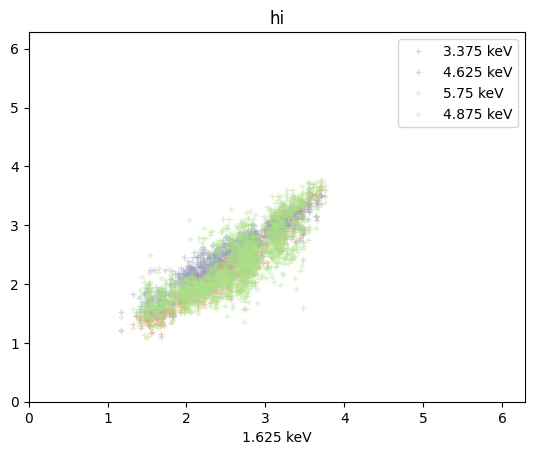

In [13]:
E_range_edges = np.array([0.5, 1, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5, 7, 8, 10])
E_range_centre = (E_range_edges[1:] + E_range_edges[:-1]) / 2

# plt.errorbar(range(len(mean_ph)),mean_ph, yerr=std, alpha=.5)
# print(E_range_centre)
mean_ph_ls = []
std_ph_ls = []

colors = ['E88D67', '9999C3', 'C0E6DE', 'ABE188', 'F78E69', 'CC2936', '2C2C54', 'CCA43B', '77B6EA']
markers = ['+', 'x', '.', '1', '*']
temp = 0
for count, cbs_vs_E_small_segs in enumerate(cbs_freq_binned):

    if count==1 or count ==3 or count ==5 or count ==6:
        
        angle_list = [] # Stores calculated cross-biphase for each 

        # Take a vector sum over cbs for each energy band
        summed_cbs = np.sum(cbs_vs_E_small_segs, axis=1)
        # Calculate cross-biphase
        a = np.angle(cbs_vs_E_small_segs)

        print(a.shape)
        # plt.plot(a[2, :], a[3, :], '.')
        # break
        for l in range(1000):
            # Generate indices to sample from
            sample_indices = np.random.randint(0, cbs_vs_E_small_segs.shape[1], size=cbs_vs_E_small_segs.shape[1])

            # Sample cbs to create new population
            sampled_cbs = cbs_vs_E_small_segs[:, sample_indices]
            # Take a vector sum over cbs for each energy band
            summed_cbs = np.sum(sampled_cbs, axis=1)
            # Calculate cross-biphase
            a = np.angle(summed_cbs)
            # Store calculated energy-dependent cross-biphase
            angle_list.append(a)
        angle_list = np.array(angle_list)
         # # Convert from -pi to pi domain to 0 to 2pi domain
        angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
        angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])
        print(angle_list.shape)
        plt.plot(angle_list[:, 5], angle_list[:, 10], marker = markers[temp], markersize=5,  label=f'{E_range_centre[9]} keV', color=f'#{colors[0]}', alpha=.4, ls='')

        plt.plot(angle_list[:, 5], angle_list[:, 15], marker = markers[temp], markersize=5,  label=f'{E_range_centre[14]} keV', color=f'#{colors[1]}', alpha=.4, ls='')

        plt.plot(angle_list[:, 5], angle_list[:, 19], marker = markers[temp], markersize=5,  label=f'{E_range_centre[18]} keV', color=f'#{colors[3]}', alpha=.4, ls='')

        plt.plot(angle_list[:, 5], angle_list[:, 16], marker = markers[temp], markersize=5,  label=f'{E_range_centre[15]} keV', color=f'#{colors[3]}', alpha=.4, ls='')

        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 2*np.pi)

        # plt.title('hi')
        plt.xlabel(f'{E_range_centre[2]} keV')
        # plt.ylabel(f'{E_range_centre[18]} keV')

        temp += 1
        break
plt.legend()
    
   


    # theta_p = angle_list.copy() # Stores phases in new 'coordinate' system

    # temp_theta_mean_list = []
    # # Calculate theta_mean, then centre distribution on theta_mean - ie, convert to new coordinate system then take mean
    # # Do this a few times to ensure that we encapsulate the distribution correctly
        
    # calc_central_phase = True
    # if calc_central_phase:
    #     # Do it per energy band because numpy arrays are confusing to wokr with
    #     # print(len(E_range_centre))
    #     for k in range(20):
            
    #         for _ in range(5):
    #             theta_mean = np.mean(theta_p[:, k])

    #             theta_p[:, k][theta_p[:, k]<theta_mean-np.pi] = 2*np.pi + theta_p[:, k][theta_p[:, k]<theta_mean-np.pi]
    #             theta_p[:, k][theta_p[:, k]>theta_mean+np.pi] = - (2*np.pi - theta_p[:, k][theta_p[:, k]>theta_mean+np.pi])

    #             if i == 4:
    #                 temp_theta_mean_list.append(np.mean(theta_p[:, k]))
                    
                    
    #                 # ax2.set_title(freq_range_labels[count])
    
    # mean_ph = np.mean(theta_p, axis=0)
    # std = np.std(theta_p, axis=0)
        
    # ax.errorbar(E_range_centre, mean_ph[1:], yerr=std[1:], label=freq_range_labels[count], 
    #             ds='steps-mid', ls='solid', alpha=.6, capsize=4, marker='x')
    # # ax.plot(E_range_centre, mean_ph[1:],  label=freq_range_labels[count], 
    # #             ds='steps-mid', ls='solid', alpha=.6, marker='x')
    
    # mean_ph_ls.append(mean_ph[1:])
    # std_ph_ls.append(std[1:])


In [146]:
import corner

In [234]:
count = 6
angle_list = [] # Stores calculated cross-biphase for each 
cbs_vs_E_small_segs = cbs_freq_binned[count]
# Take a vector sum over cbs for each energy band
summed_cbs = np.sum(cbs_vs_E_small_segs, axis=1)
# Calculate cross-biphase
a = np.angle(cbs_vs_E_small_segs)

print(a.shape)
# plt.plot(a[2, :], a[3, :], '.')
# break
for l in range(1000):
    # Generate indices to sample from
    sample_indices = np.random.randint(0, cbs_vs_E_small_segs.shape[1], size=cbs_vs_E_small_segs.shape[1])

    # Sample cbs to create new population
    sampled_cbs = cbs_vs_E_small_segs[:, sample_indices]
    # Take a vector sum over cbs for each energy band
    summed_cbs = np.sum(sampled_cbs, axis=1)
    # Calculate cross-biphase
    a = np.angle(summed_cbs)
    # Store calculated energy-dependent cross-biphase
    angle_list.append(a)
angle_list = np.array(angle_list)
    # # Convert from -pi to pi domain to 0 to 2pi domain
angle_list[angle_list<0] = np.pi*2+angle_list[angle_list<0]
angle_list[angle_list>2*np.pi] = -(2*np.pi - angle_list[angle_list>2*np.pi])

        

(20, 5482)


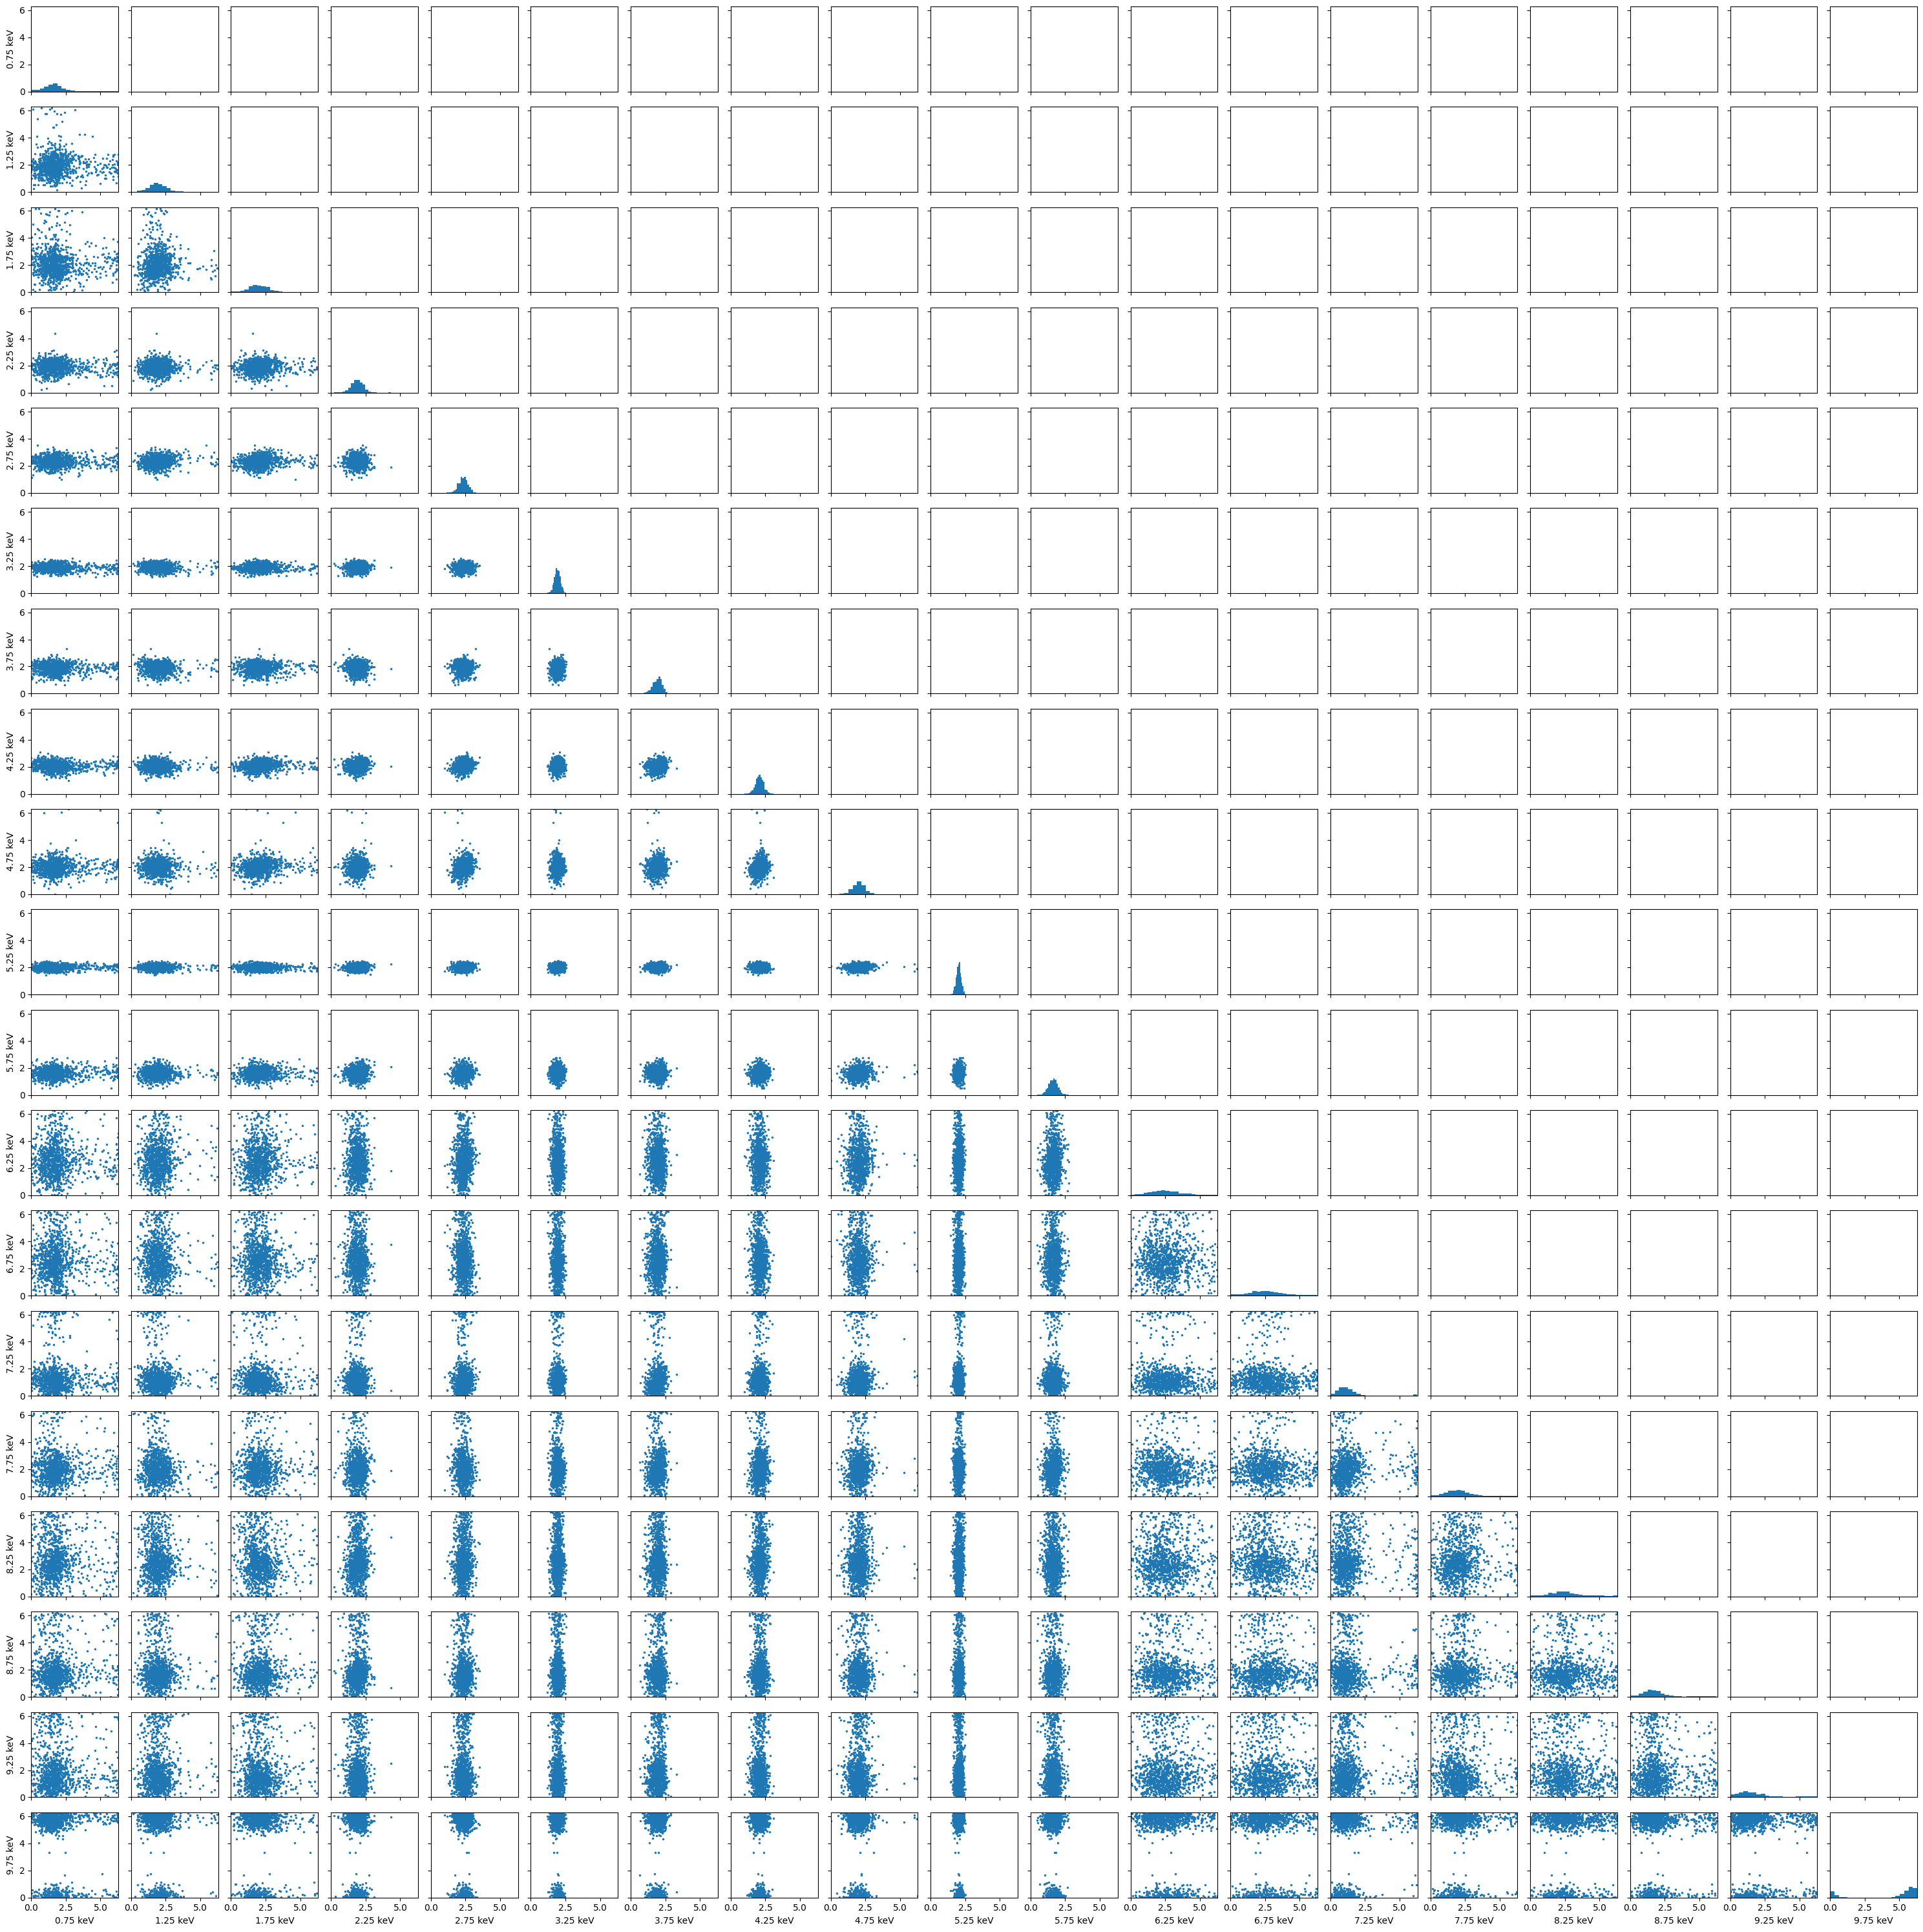

In [ ]:
figs = 19
fig, ax = plt.subplots(figs, figs, figsize=(30,30), sharex=True, sharey=True)
# for i in range(0, figs-1):
#     for j in range(0,figs-i-1):
#         if i == j:
#             ax[j][i].hist(angle_list[:, i], bins=20, density=True)
#         else:
#             ax[j][i].plot(angle_list[:, i], angle_list[:, j], '.', markersize=3)
#         if i == 0:
#             ax[j][i].set_xlabel('Hi')

for j in range(0, figs):
    for i in range(0, j+1):
        # print(j,i)
        if i == j:
            ax[j][i].hist(angle_list[:, i+1], bins=20, density=True)
        else:
            ax[j][i].plot(angle_list[:, i+1], angle_list[:, j+1], '.', markersize=3)
        
        if j == figs-1:
            ax[j][i].set_xlabel(f'{E_range_centre[i]} keV')
        if i == 0:
            ax[j][i].set_ylabel(f'{E_range_centre[j]} keV')

plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)

fig.tight_layout()

In [236]:
fig.savefig('TempFigure_CornerPlot_count6.pdf', dpi=600)

# Average count rates in different observations

In [14]:
from pypalettes import load_cmap
cmap = load_cmap("Classic_10_Medium")
colors = cmap.colors

Loaded 10 big segments into events_split_by_time
Loaded fund freqs and fwhm from:
../../data/processed/20250507_FrequencyDependentBinning//FinerEnergyBinning2/ni1050360104/PspecFits/pspec_fit_result.npz
Working on big seg 0
Working on big seg 1
Working on big seg 2
Working on big seg 3
Working on big seg 4
Working on big seg 5
Working on big seg 6
Working on big seg 7
Working on big seg 8
Working on big seg 9
Loaded 14 big segments into events_split_by_time
Loaded fund freqs and fwhm from:
../../data/processed/20250507_FrequencyDependentBinning//FinerEnergyBinning2/ni1050360105/PspecFits/pspec_fit_result.npz
Working on big seg 0
Working on big seg 1
Working on big seg 2
Working on big seg 3
Working on big seg 4
Working on big seg 5
Working on big seg 6
Working on big seg 7
Working on big seg 8
Working on big seg 9
Working on big seg 10
Working on big seg 11
Working on big seg 12
Working on big seg 13
Loaded 11 big segments into events_split_by_time
Loaded fund freqs and fwhm from:
../.

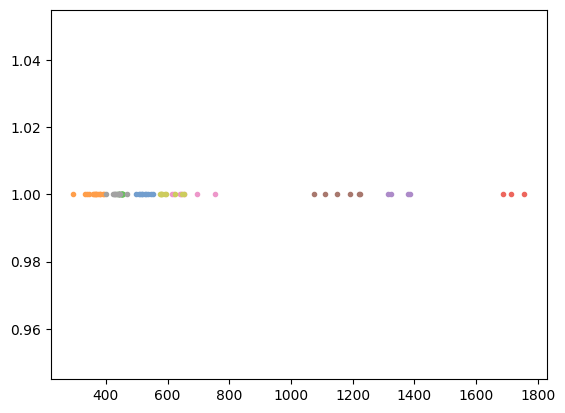

In [17]:
for c, obsid in enumerate(obsids):
    # obsid = obsids[8]
    # Directory to load
    file_dir = data_dir + f'raw/MAXI/{obsid}_0mpu7_cl.evt'

    # Working directory to store all the pspec fit results
    # Will also check this directory for whether fit results are already present
    obs_dir = f'{data_dir}processed/20250507_FrequencyDependentBinning//FinerEnergyBinning2/{obsid}/'

    bigsegs_dir = f'{obs_dir}bigsegs/'

    load_fund_freq_from = f'{obs_dir}PspecFits/pspec_fit_result.npz'

    # Check how many pickle files of splitevs exist
    count_pickle = 0
    for file in os.listdir(bigsegs_dir):
        if file.endswith('.p') and file.startswith('splitev'):
            count_pickle += 1

    # Load big segments
    events_split_by_time = []
    for i in range(count_pickle):
        ev_file_dir = f'{bigsegs_dir}splitev_{obsid}_{i}.p'
        ev_loaded = st.EventList.read(ev_file_dir, "pickle")
        events_split_by_time.append(ev_loaded)

    print(f'Loaded {len(events_split_by_time)} big segments into events_split_by_time')

    temp_loader = np.load(load_fund_freq_from)
    fund_central_f = temp_loader['f_cent']
    fund_fwhm = temp_loader['f_fwhm']

    print(f'Loaded fund freqs and fwhm from:\n{load_fund_freq_from}')

    dt = 1/64
    E_range_edges = np.array([0.5, 1, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5, 7, 8, 10])
    E_range_centre = (E_range_edges[1:] + E_range_edges[:-1]) / 2

    for count, ev in enumerate(events_split_by_time):
        print("Working on big seg", count)
        
        # Set segment size for cbsepc based on qpo frequency
        Cbspec_segsize = 10
        
        # Assuming Q = 8 to get FWHM
        Q = 8
        fwhm = fund_central_f[count]/Q
        
        # Filter out reference band light curve
        E_ref = [2, 10]
        EnergyLabels = [f'{E_ref[0]:.1f}-{E_ref[1]:.1f} KeV']
        
        events_E_ref = ev.filter_energy_range(E_ref)
        # events_filtered = [events_E_ref]
        
        # lc_ref = events_filtered[0].to_lc(dt=dt)
        # segmented_counts_E_ref, segmented_times_E_ref, discard = split_multiple_lc(lc_ref.split_by_gti(), Cbspec_segsize, dt=dt)

        ctrate = st.fourier.get_average_ctrate(events_E_ref.time, events_E_ref.gti, Cbspec_segsize)
        plt.plot(ctrate,1, '.', c=colors[c])

In [ ]:
freq_bin_ranges = [1.7, 2, 3, 4, 5]
# freq_bin_ranges = [1.5, 2, 2.5, 3]
# freq_bin_ranges = [1.5, 2.5, 3.5, 4.5, 6]
freq_range_labels = []
len_list = []
cbs_freq_binned = []
project_dir = 'C:/Users/shash/UvA/Thesis/Project/MastersThesis/'
for i in range(len(freq_bin_ranges)):
    if i == 0:
        pass
    else:
        freq_range_labels.append(f'{freq_bin_ranges[i-1]:.2f} to {freq_bin_ranges[i]:.2f} Hz')
        print('Loading', freq_range_labels[-1])
        print('---------------')

        for obsid in obsids:
            obs_dir = f'{project_dir}data/processed/20250507_FrequencyDependentBinning/FinerEnergyBinning2/{obsid}/'
            load_freq_from = f'{obs_dir}PspecFits/pspec_fit_result.npz'
            load_cbs_from = f'{obs_dir}cbs_arrs/'
            load_bigsegs_from = f'{obs_dir}bigsegs/'

            a = np.load(load_freq_from)
            fund_central_f = a['f_cent']
            fund_fwhm = a['f_fwhm']
            
            # Find "Big Segments" in which frequencies are in the correct range, then append
            csb_vs_E = None
            undefined = True
            for j in range(len(fund_central_f)):
                if fund_central_f[j] > freq_bin_ranges[i-1] and fund_central_f[j] <= freq_bin_ranges[i]:
                    cbs_temp = np.load(f'{load_cbs_from}cbs_from_bigsegs_ind_{j}.npy')
                    if undefined:
                        cbs_vs_E = cbs_temp.copy()
                        undefined=False
                    else:
                        cbs_vs_E = np.append(cbs_vs_E, cbs_temp.copy(), axis=1)
                        print(cbs_vs_E.shape)